In [1]:
## Imports
import pandas as pd
import tensorflow as tf
import numpy as np

!pip install -q efficientnet
import efficientnet.tfkeras as efn

from tqdm import tqdm

import math
from math import ceil, floor, log
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# Setting up constants
SEED = 5
N_epochs = 30

In [3]:
#Load data and cut off bad quality ones
df = pd.read_csv('labels.csv')
df = df.query('photo_quality == 1')
df['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [4]:
#Set up models to be run
MODELS = {
          'ResNet50':[tf.keras.applications.ResNet50,32,300],
         # 'DenseNet121':[tf.keras.applications.DenseNet121,32,300],
         }

In [5]:
# Replace \ with / to make the path work
for idx in tqdm(df.index):    
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/') 

100%|██████████| 7035/7035 [00:03<00:00, 2291.58it/s]


In [6]:
#List of columns we are interested in
labels_cols = ['is_bee', 'is_wasp', 'is_otherinsect', 'is_other']

#Split data into training, validation, and test data
df_train = df.loc[(df.is_validation == 0) & (df.is_final_validation == 0)]
df_valid = df.loc[(df.is_validation == 1)]
df_test = df.loc[(df.is_final_validation == 1)]

In [7]:
y_train = df_train.loc[:,['id']+labels_cols]
y_train.set_index('id', inplace = True)
y_valid = df_valid.loc[:,['id']+labels_cols]
y_valid.set_index('id', inplace = True)
y_test = df_test.loc[:,['id']+labels_cols]
y_test.set_index('id', inplace = True)

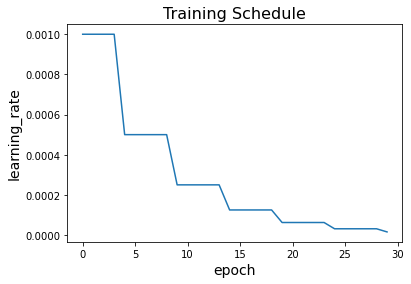

In [8]:

def get_lr_callback(plot=False):
    start_lr = 0.001
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 5.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(N_epochs)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               monitor='val_loss',
                                               verbose=1, 
                                               restore_best_weights=True)
lr = get_lr_callback(plot=True)



In [9]:
#Værdier til instantiering af ImageDataGenerator er taget fra eksemplet fundet under afsnittet 'Set up the Flowers dataset' på https://www.tensorflow.org/hub/tutorials/tf2_image_retraining

def gen_init(BS, IMG_Size):
    #Vi normalisere trænings dataene
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip = True,
        width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2)

    train_generator = train_gen.flow_from_dataframe(dataframe=df_train, 
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

    #Data til validering skal ikke normaliseres, men vi skalerer det til samme opløsning som træningsdataene
    valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)    
    
    
    valid_generator = valid_gen.flow_from_dataframe(dataframe=df_valid,
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  # class_mode="categorical", 
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

    #Data til test skal heller ikke normaliseres, men vi skalerer det ligeledes  
    test_generator = valid_gen.flow_from_dataframe(dataframe=df_test,
                                                  x_col="path", y_col=labels_cols, 
                                                  class_mode="raw", 
                                                  shuffle = False,
                                                  target_size=(IMG_Size,IMG_Size), batch_size = BS)

    return   train_generator,   valid_generator, test_generator

In [10]:
train_generator, valid_generator, test_generator = gen_init(32,200)

Found 4908 validated image filenames.
Found 1043 validated image filenames.
Found 1084 validated image filenames.


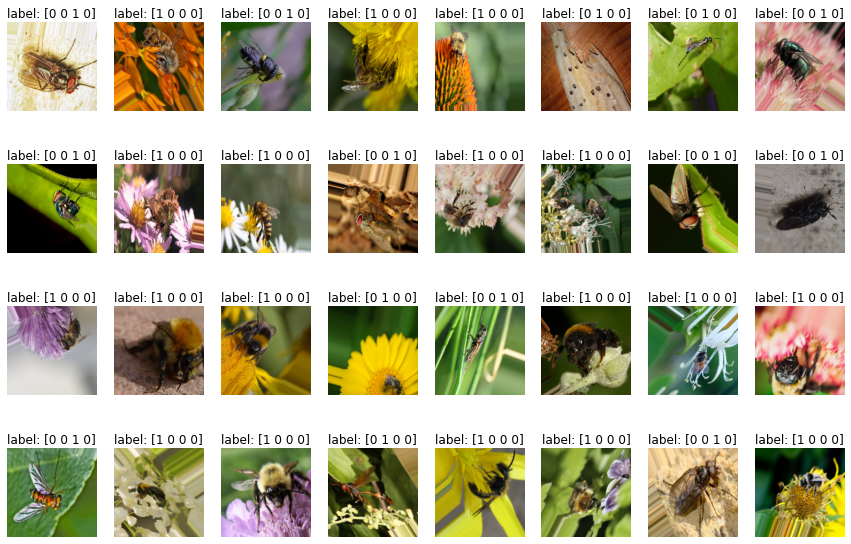

In [11]:
ti, tl = train_generator.next()
imgs = []
for i in range(ti.shape[0]):
    img = np.array(ti[i]*255, dtype = 'int32')
    imgs.append(img)

f, ax = plt.subplots(4, 8, figsize=(15,10))
for i, img in enumerate(imgs):
    ax[i//8, i%8].imshow(img)
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title('label: %s' % tl[i])
plt.show()

In [12]:
def build_model(model_engine, IMG_Size):
    inp = tf.keras.layers.Input(shape=(IMG_Size,IMG_Size,3))
    base = model_engine(input_shape=(IMG_Size,IMG_Size,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(4,activation='softmax')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)   
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
all_model = []
all_history = []
all_preds = []
all_accuracies = []
all_recalls = []
all_precisions = []
all_confusion_matrices = []

Found 4908 validated image filenames.
Found 1043 validated image filenames.
Found 1084 validated image filenames.
------------------------------------------------------------------
Training model  ResNet50
Epoch 1/30
154/153 [==============================] - 3901s 25s/step - loss: 0.8940 - accuracy: 0.6722 - val_loss: 1.3549 - val_accuracy: 0.3423
Epoch 2/30
154/153 [==============================] - 3809s 25s/step - loss: 0.5766 - accuracy: 0.7751 - val_loss: 1.1748 - val_accuracy: 0.3423
Epoch 3/30
154/153 [==============================] - 3752s 24s/step - loss: 0.4873 - accuracy: 0.8128 - val_loss: 1.1604 - val_accuracy: 0.3442
Epoch 4/30
154/153 [==============================] - 3637s 24s/step - loss: 0.4836 - accuracy: 0.8274 - val_loss: 1.2742 - val_accuracy: 0.3126
Epoch 5/30
154/153 [==============================] - 3643s 24s/step - loss: 0.3764 - accuracy: 0.8576 - val_loss: 1.0920 - val_accuracy: 0.5379
Epoch 6/30
154/153 [==============================] - 3625s 24s/step 

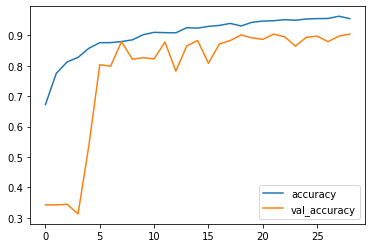

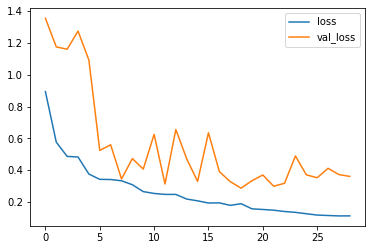

34/34 [==============================] - 101s 3s/step


NameError: name 'precision_score' is not defined

In [14]:
for model_name in MODELS:
    engine = MODELS[model_name][0]
    BS = MODELS[model_name][1]
    IMG_Size = MODELS[model_name][2]
    train_generator, valid_generator, test_generator = gen_init(BS, IMG_Size)
    
    model = build_model(engine, IMG_Size)
    print('------------------------------------------------------------------')
    print('Training model ', model_name)
    history = model.fit(train_generator,
              steps_per_epoch=len(df_train) / BS, epochs = N_epochs, verbose = 1,
              callbacks=[es_callback, get_lr_callback(BS)],
              validation_data = valid_generator)

    model.save('model-%s.h5'%model_name)  
    all_history.append(history)
    
    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.show()

    preds = model.predict(test_generator, verbose = 1)
    all_preds.append(preds)
    cm = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(preds, axis = 1))
    all_confusion_matrices.append(cm)
    acc = accuracy_score(np.argmax(np.array(y_test), axis=1), np.argmax(preds, axis = 1))    
    all_accuracies.append(acc)
    prec = precision_score(np.argmax(np.array(y_test), axis=1), np.argmax(preds, axis = 1))    
    all_precisions.append(prec)
    recall = recall_score(np.argmax(np.array(y_test), axis=1), np.argmax(preds, axis = 1))    7
    all_recalls.append(recall)
    
    
    print('------------------------------------------------------------------')
    print(cm)
    print(acc)
    print(prec)
    print(recall)

In [16]:
print('------------------------------------------------------------------')
print(cm)
print(acc)

------------------------------------------------------------------
[[364  13   3]
 [ 22 278  28]
 [ 12  32 332]]
0.8985239852398524


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].